# 1. Подготовка данных

Подключим необходимые модули

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### 1.1 Открытие файлов и изучение:

In [2]:
# этот блок добавлен, потому что выполнял на ПК Windows, чтобы не ошибиться и не переписывать для работы на серере
path_data_train = os.path.normpath('datasets/gold_recovery_train.csv')
path_data_test = os.path.normpath('datasets/gold_recovery_test.csv')
path_data_full = os.path.normpath('datasets/gold_recovery_full.csv')

Откроем тренировочные данные:

In [3]:
data_train = pd.read_csv(path_data_train)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Откроем тестовые данные:

In [4]:
data_test = pd.read_csv(path_data_test)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Откроем полные данные:

In [5]:
data_full = pd.read_csv(path_data_full)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [6]:
print('Всего объектов: {:} шт. Из них в тренировочной выборке: {:} шт. и в тестовой {:} шт.'.format(data_full.shape[0], data_test.shape[0], data_test.shape[0]))

Всего объектов: 22716 шт. Из них в тренировочной выборке: 5856 шт. и в тестовой 5856 шт.


Данные имеют пропуски.

Данные содержат много признаков. Индексом является дата. <br>
Наименование признаков содержит имеет вид: этап.тип-параметра.название-параметра <br>
Возможные значения для *этап*:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для *тип-параметра*:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики



### 1.2 Проверка правильности расчёта эффективности обогащения

Вычислим эффективность обогащения на обучающей выборке для признака чернового сырья и финального концентрата. Найдём MAE между расчётными значениями и значением признака.

Для расчёта recovery напишем функцию, которая принимает 3 аргумента:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки; 

и возвращает значение эффективности обогащения в процентах:

In [7]:
def recovery_calc(c, f, t):
    return (c * (f - t)) / (f * (c - t)) * 100

In [8]:
data_train['rougher.calculation.recovery'] = recovery_calc(
    c=data_train['rougher.output.concentrate_au'],
    f=data_train['rougher.input.feed_au'],
    t=data_train['rougher.output.tail_au'])

In [9]:
print('Значение среднего абсолютного отклонения (MAE) для вычисленного признака эффективности обогащения чернового концентрата для обучающей выборки: {:.3} %'.format(mean_absolute_error(
    data_train[(data_train['rougher.output.recovery'] > 0) & (data_train['rougher.calculation.recovery'] > 0)]['rougher.output.recovery'], 
    data_train[(data_train['rougher.output.recovery'] > 0) & (data_train['rougher.calculation.recovery'] > 0)]['rougher.calculation.recovery'])))

Значение среднего абсолютного отклонения (MAE) для вычисленного признака эффективности обогащения чернового концентрата для обучающей выборки: 9.66e-15 %


Судя по малой величине MAE, значение эффективности обогащения в выборке посчитано верно.

Проведём аналогичные действия для расчёта эффективности обогащения финального концентрата:

In [10]:
data_train['final.calculation.recovery'] = recovery_calc(
    c=data_train['final.output.concentrate_au'],
    f=data_train['rougher.input.feed_au'],
    t=data_train['final.output.tail_au'])

In [11]:
print('Значение среднего абсолютного отклонения (MAE) для вычисленного признака эффективности обогащения финального концентрата для обучающей выборки: {:.3} %'.format(
    mean_absolute_error(data_train[(data_train['final.output.recovery'] > 0) & (data_train['final.calculation.recovery'] > 0)]['final.output.recovery'], 
    data_train[(data_train['final.output.recovery'] > 0) & (data_train['final.calculation.recovery'] > 0)]['final.calculation.recovery'])))

Значение среднего абсолютного отклонения (MAE) для вычисленного признака эффективности обогащения финального концентрата для обучающей выборки: 8.21e-15 %


### 1.3 Анализ признаков, недоступных в тестовой выборке

In [12]:
print('В тестовой выборке отсутствуют следующие признаки:\n')
missing_features = list(set(data_train)^set(data_test))
for i in missing_features:
    print(i)

В тестовой выборке отсутствуют следующие признаки:

final.output.tail_sol
rougher.output.tail_au
primary_cleaner.output.tail_au
secondary_cleaner.output.tail_ag
rougher.output.recovery
rougher.output.concentrate_au
final.output.concentrate_ag
final.output.recovery
rougher.calculation.recovery
primary_cleaner.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.tail_sol
rougher.calculation.floatbank10_sulfate_to_au_feed
final.output.concentrate_pb
rougher.output.concentrate_pb
rougher.calculation.au_pb_ratio
primary_cleaner.output.tail_pb
rougher.output.concentrate_sol
rougher.output.tail_ag
secondary_cleaner.output.tail_sol
primary_cleaner.output.concentrate_pb
final.calculation.recovery
final.output.tail_au
final.output.concentrate_au
rougher.calculation.floatbank11_sulfate_to_au_feed
secondary_cleaner.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.tail_sol
final.output.tail_pb
final.output.tail_ag
primary_cleaner.output.tail_ag
rougher.calcu

Из вышеприведённого анализа видно, что в тестовых данных отсутствуют параметры продукта и расчётные характеристики. <br>


### 1.4 Предобработка данных

Напишем функцию фильтрации выбросов <br>
На вход она принимает признак, возвращает признак выброса. <br>
Выбросом будут считаться значения больше 3 квартили плюс 1.5 межквартильных размаха и меньше 1 квартили минус 1.5 межквартильных размаха

In [13]:
def filtering_outliers(data):
    iqr = data.quantile(q=0.75) - data.quantile(q=0.25)
    max = 1.5 * iqr + data.quantile(q=0.75)
    min = data.quantile(q=0.25) - 1.5 * iqr
    return (data < min) | (data > max)

Напишем функцию для замен пропущенных значений и выбросов на расчётные <br>
На вход она принимает строку, имя целевого столбца, имя столбца с признаком выброса и имя столбца с расчётным значением:

In [14]:
def replace_to_calculate(row, target, discharge, calc):
    if row[discharge] | ~(row[target]>0):
        return row[calc]
    else:
        return row[target]

Напишем функцию для замены всех пропущенных значений средним:

In [15]:
def fillna_to_mean(data):
    for feature in list(data)[1:]:
        data[feature] = data[feature].fillna(data[feature].mean())
    return data

Напишем функцию для замены всех пропущенных значений соседними по времени:

In [16]:
def fillna_to_neighbour(data):
    sort_save = data['date']
    data = data.sort_values('date').reset_index(drop=True)
    for feature in list(data)[1:]:
        col = data[feature]
        passes = col.isnull()
        passes = passes[passes == True]  # нашли пропущенные значения и их индексы
        passes_ind = list(passes.index) # нашли индексы пропущенных значений
        for p in passes_ind:  # итерируемся по индексам пропущенных значений
            ind_less=0
            ind_more=np.array(list(col.index)).max()
            for i in range(p-1, 0, -1):  # находим индекс ближайшего известного меньше
                if i not in passes_ind:
                    ind_less = i
                    break
            for i in range(p+1, ind_more):  # находим индекс ближайшего известного больше
                if i not in passes_ind:
                    ind_more = i
                    break
            val_less = col[ind_less]  # находим ближайшее значение с меньшим индексом
            val_more = col[ind_more]  # находм ближайшее значение с большим индесом
            val_replace =  ((val_more - val_less) / (ind_more - ind_less)) * (p - ind_less) + val_less
            col.loc[p] = val_replace
        data[feature] = col
    return pd.merge(left=sort_save, right=data, on='date')

Для начала удалим из тестовых даннх объекты, не имеющие признаков (или имеющие некорректные), без которых, мы не сможем рассчитать целевой признак:

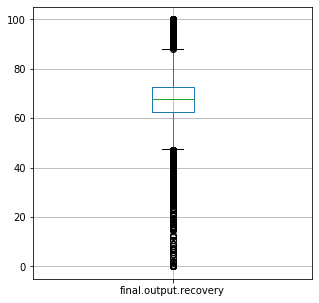

In [17]:
data_train.boxplot('final.output.recovery', figsize=(5,5));

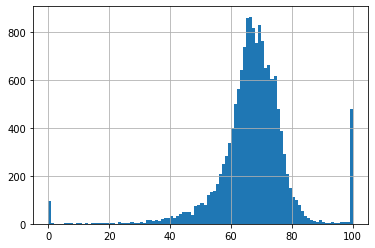

In [18]:
data_train['final.output.recovery'].hist(bins=100);

In [19]:
data_train['final.output.recovery'].describe()

count    15339.000000
mean        67.213166
std         11.960446
min          0.000000
25%         62.625685
50%         67.644601
75%         72.824595
max        100.000000
Name: final.output.recovery, dtype: float64

Пометим выбросы признака *final.output.recovery* и заменим их и пропущенные значения на расчётные:

Определим признаки *final.output.recovery*, которые являются выбросами

In [20]:
data_train['final.output.recovery_discharge'] = filtering_outliers(data_train['final.output.recovery'])

Заменим признаки *final.output.recovery*, которые являются выбросами на правильно рассчитанные значения

In [21]:
data_train['final.output.recovery'] = data_train.apply(replace_to_calculate, axis=1, args=('final.output.recovery', 'final.output.recovery_discharge', 'final.calculation.recovery'))

Удалим ненужные столбцы - с признаком выбросов и расчётным значением

In [22]:
data_train = data_train.drop(['final.output.recovery_discharge', 'final.calculation.recovery'], axis=1)

Удалим объекты, признак которых не удалось восстановить:

In [23]:
data_train = data_train.dropna(subset=['final.output.recovery'], axis='rows')

Среди новых данных найдём выбросы:

In [24]:
data_train['final.output.recovery_discharge'] = filtering_outliers(data_train['final.output.recovery'])

Удалим выбросы и ненужный признак выбросов:

In [25]:
data_train = data_train[data_train['final.output.recovery_discharge'] == False]

In [26]:
data_train = data_train.drop(['final.output.recovery_discharge'], axis=1)

Оценим результаты обработки:

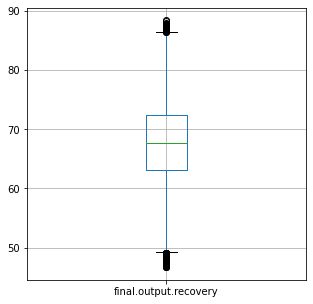

In [27]:
data_train.boxplot('final.output.recovery', figsize=(5,5));

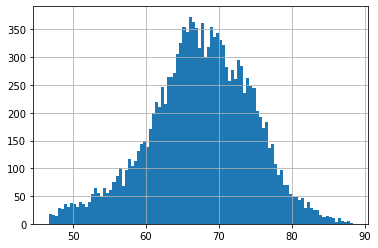

In [28]:
data_train['final.output.recovery'].hist(bins=100);

In [29]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14198 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14198 non-null  object 
 1   final.output.concentrate_ag                         14197 non-null  float64
 2   final.output.concentrate_pb                         14197 non-null  float64
 3   final.output.concentrate_sol                        13999 non-null  float64
 4   final.output.concentrate_au                         14198 non-null  float64
 5   final.output.recovery                               14198 non-null  float64
 6   final.output.tail_ag                                14198 non-null  float64
 7   final.output.tail_pb                                14121 non-null  float64
 8   final.output.tail_sol                               14173 non-null  float64


Проведём аналогичную обработку для *rougher.output.recovery*:

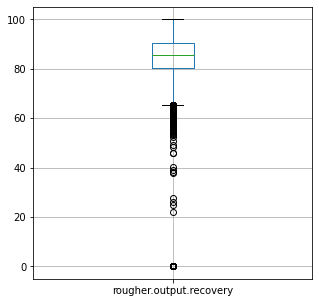

In [30]:
data_train.boxplot('rougher.output.recovery', figsize=(5,5));

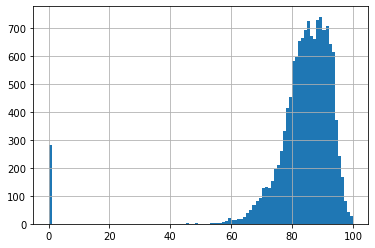

In [31]:
data_train['rougher.output.recovery'].hist(bins=100);

Пометим выбросы признака *rougher.output.recovery* и заменим их и пропущенные значения на расчётные:

In [32]:
data_train['rougher.output.recovery_discharge'] = filtering_outliers(data_train['rougher.output.recovery'])

In [33]:
data_train['rougher.output.recovery'] = data_train.apply(replace_to_calculate, axis=1, args=('rougher.output.recovery', 'rougher.output.recovery_discharge', 'rougher.calculation.recovery'))

Удалим ненужные столбцы - с признаком выбросов и расчётным значением

In [34]:
data_train = data_train.drop(['rougher.output.recovery_discharge', 'rougher.calculation.recovery'], axis=1)

Удалим объекты, признак которых не удалось восстановить:

In [35]:
data_train = data_train.dropna(subset=['rougher.output.recovery'], axis='rows')

Среди новых данных найдём выбросы:

In [36]:
data_train['rougher.output.recovery_discharge'] = filtering_outliers(data_train['rougher.output.recovery'])

Удалим выбросы и ненужный признак выбросов:

In [37]:
data_train = data_train[data_train['rougher.output.recovery_discharge'] == False]

In [38]:
data_train = data_train.drop(['rougher.output.recovery_discharge'], axis=1)

Оценим результаты обработки:

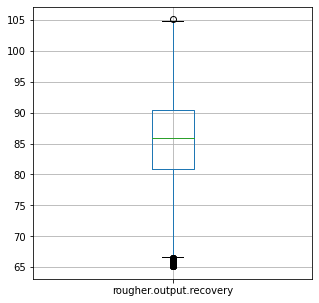

In [39]:
data_train.boxplot('rougher.output.recovery', figsize=(5,5));

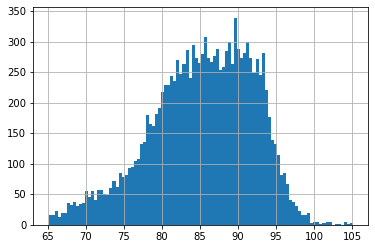

In [40]:
data_train['rougher.output.recovery'].hist(bins=100);

Посмотрим на оставшиеся пропущенные значения:

In [41]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13090 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                13090 non-null  object 
 1   final.output.concentrate_ag                         13089 non-null  float64
 2   final.output.concentrate_pb                         13089 non-null  float64
 3   final.output.concentrate_sol                        12935 non-null  float64
 4   final.output.concentrate_au                         13090 non-null  float64
 5   final.output.recovery                               13090 non-null  float64
 6   final.output.tail_ag                                13090 non-null  float64
 7   final.output.tail_pb                                13016 non-null  float64
 8   final.output.tail_sol                               13087 non-null  float64


Осталось не много пропущенных значений. Заменим их средним на значения, соседние по времени, т.к. они часто похожи:

In [42]:
data_train = fillna_to_neighbour(data_train)

c:\users\sceli\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Далее обработаем данные тестовой выборки:

In [43]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Пропусков не много. Заменим их на средние значения:

In [44]:
data_test = fillna_to_neighbour(data_test)

Предобработка данных завершена!

# 2. Анализ данных

### 2.1. Изучение концентрации металлов на различных этапах очистки

Посмотритм, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [45]:
x_names = ['rougher.input',
     'rougher.output',
     'primary_cleaner.output',
     'final.output']
mean_au = [data_train['rougher.input.feed_au'].mean(), 
        data_train['rougher.output.concentrate_au'].mean(),
        data_train['primary_cleaner.output.concentrate_au'].mean(), 
        data_train['final.output.concentrate_au'].mean()]
mean_ag = [data_train['rougher.input.feed_ag'].mean(), 
        data_train['rougher.output.concentrate_ag'].mean(),
        data_train['primary_cleaner.output.concentrate_ag'].mean(), 
        data_train['final.output.concentrate_ag'].mean()]
mean_pb = [data_train['rougher.input.feed_pb'].mean(), 
        data_train['rougher.output.concentrate_pb'].mean(),
        data_train['primary_cleaner.output.concentrate_pb'].mean(), 
        data_train['final.output.concentrate_pb'].mean()]
mean_sol = [data_train['rougher.input.feed_sol'].mean(), 
        data_train['rougher.output.concentrate_sol'].mean(),
        data_train['primary_cleaner.output.concentrate_sol'].mean(), 
        data_train['final.output.concentrate_sol'].mean()]

substances_stages = pd.DataFrame(data=[mean_au, mean_ag, mean_pb, mean_sol], columns=x_names, index=['Au', 'Ag', 'Pb', 'Sol']).T

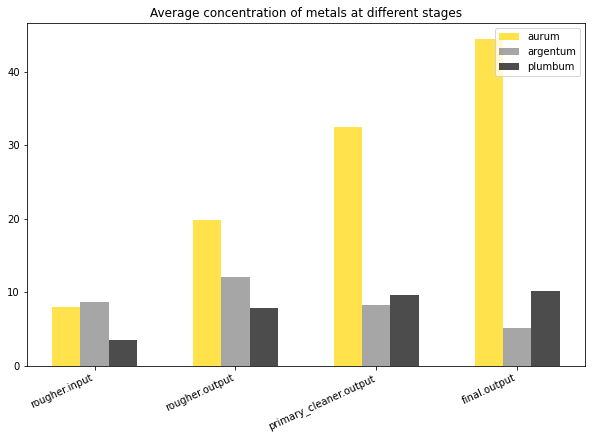

In [46]:
xs = range(len(x_names))


fig = plt.figure(figsize=(10, 7))
plt.title('Average concentration of metals at different stages')


plt.bar([x - 0.2 for x in xs], mean_au,
        width = 0.2, color = 'gold', alpha = 0.7, label = 'aurum',
        zorder = 2)
plt.bar([x for x in xs], mean_ag,
        width = 0.2, color = 'gray', alpha = 0.7, label = 'argentum',
        zorder = 2)
plt.bar([x + 0.2 for x in xs], mean_pb,
        width = 0.2, color = 'black', alpha = 0.7, label = 'plumbum',
        zorder = 2)
plt.xticks(xs, x_names)
fig.autofmt_xdate(rotation = 25)
plt.legend(loc='upper right');

По мере прохождения золотосодержащей руды различных этапов очистики концентрация золота в ней сльно повышается <br>
Концентрация серебра немного повышается после флотации, затем снижается при очистке <br>
Концентрация свинца повышается на всех этапах технологического процесса.<br>
Повышение концентрации свинца, возможно, связано со снижением концентрации остальных примесей по мере очистки.

### 2.2. Сравнение распределения размеров гранул сырья

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

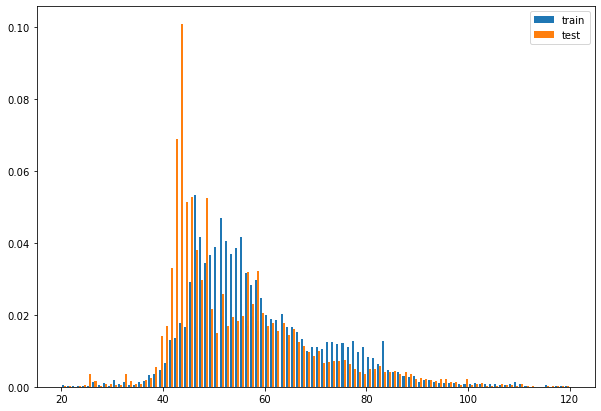

In [47]:
plt.figure(figsize=(10, 7))
plt.hist(x=[data_train['rougher.input.feed_size'], 
            data_test['rougher.input.feed_size']], 
         bins=100, range=(20,120), density=True, label=['train', 'test'])
plt.legend(loc='upper right');

Распределения размеров гранул сырья на обучающей и тестовой выборках имеют похожий вид. И т.к. распределения сильно не отличаются друг от друга, то оценка модели может быть правильноый и для тестовых данных.

### 2.3. Исследование суммарной концентрации веществ на разных стадиях

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

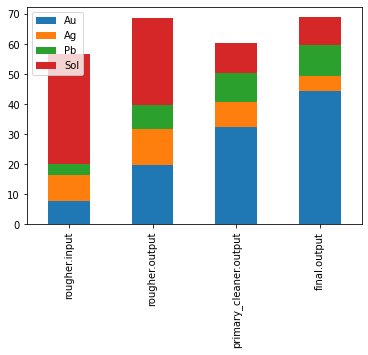

In [48]:
ax = substances_stages.plot.bar(stacked=True);

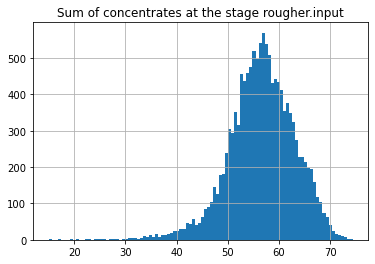

In [49]:
plt.title('Sum of concentrates at the stage rougher.input')
(data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_ag'] + data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']).hist(bins=100);

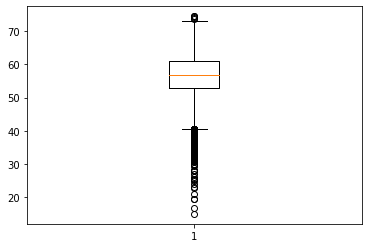

In [50]:
plt.boxplot((data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_ag'] + data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']));

In [51]:
# удалим выбросы
data_train = data_train[(data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_ag'] + data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']) > 40]

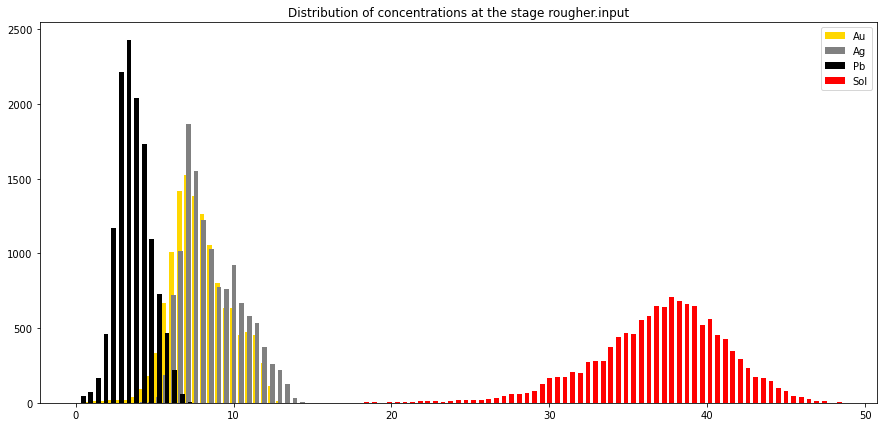

In [52]:
plt.figure(figsize=(15, 7))
plt.title('Distribution of concentrations at the stage rougher.input')
plt.hist([data_train['rougher.input.feed_au'], data_train['rougher.input.feed_ag'], data_train['rougher.input.feed_pb'], data_train['rougher.input.feed_sol']],
         bins=100, color=['gold', 'gray', 'black', 'red'],
        label=['Au', 'Ag', 'Pb', 'Sol'], width = 0.3);
plt.legend(loc='upper right');

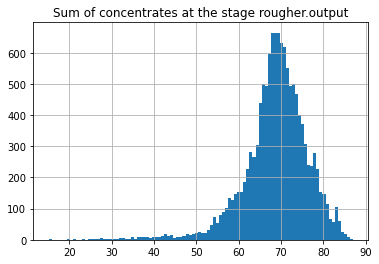

In [53]:
plt.title('Sum of concentrates at the stage rougher.output')
(data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] + data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_sol']).hist(bins=100);

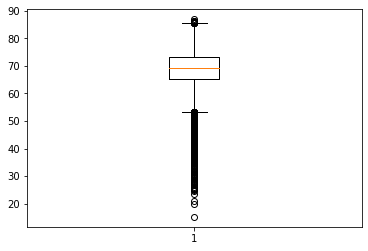

In [54]:
plt.boxplot((data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] + data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_sol']));

In [55]:
# удалим выбросы
data_train = data_train[(data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] + data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_sol']) > 50]

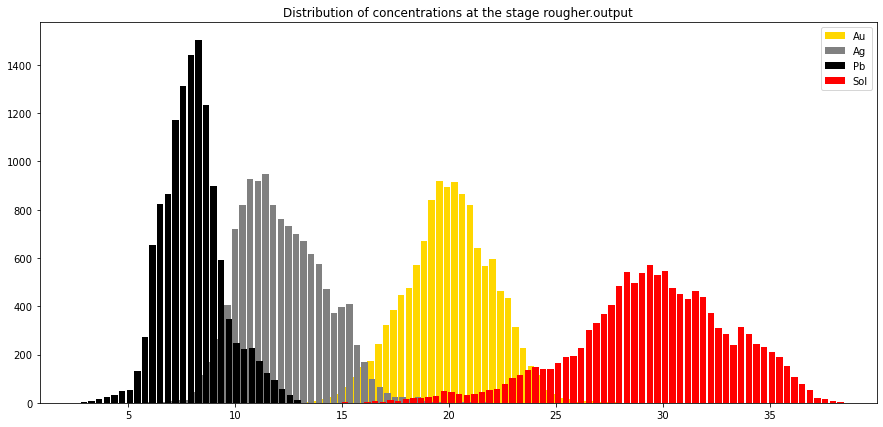

In [56]:
plt.figure(figsize=(15, 7))
plt.title('Distribution of concentrations at the stage rougher.output')
plt.hist([data_train['rougher.output.concentrate_au'], data_train['rougher.output.concentrate_ag'], data_train['rougher.output.concentrate_pb'], data_train['rougher.output.concentrate_sol']],
         bins=100, color=['gold', 'gray', 'black', 'red'],
        label=['Au', 'Ag', 'Pb', 'Sol'], width = 0.3);
plt.legend(loc='upper right');

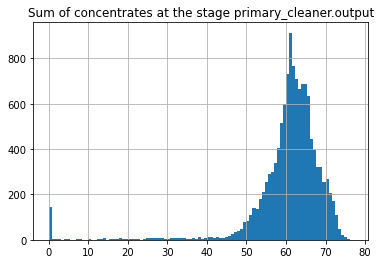

In [57]:
plt.title('Sum of concentrates at the stage primary_cleaner.output')
(data_train['primary_cleaner.output.concentrate_au'] + data_train['primary_cleaner.output.concentrate_ag'] + data_train['primary_cleaner.output.concentrate_pb']+data_train['primary_cleaner.output.concentrate_sol']).hist(bins=100);

{'whiskers': [<matplotlib.lines.Line2D at 0x1ceca43b9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ceca43bf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ceca582fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ceca55c220>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ceca55c340>],
 'means': []}

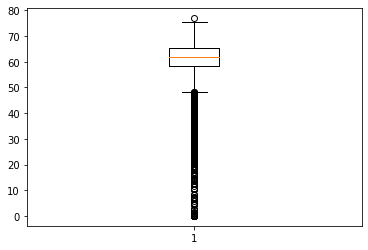

In [58]:
plt.boxplot((data_train['primary_cleaner.output.concentrate_au'] + data_train['primary_cleaner.output.concentrate_ag'] + data_train['primary_cleaner.output.concentrate_pb']+data_train['primary_cleaner.output.concentrate_sol']))

In [59]:
# удалим выбросы
data_train = data_train[(data_train['primary_cleaner.output.concentrate_au'] + data_train['primary_cleaner.output.concentrate_ag'] + data_train['primary_cleaner.output.concentrate_pb']+data_train['primary_cleaner.output.concentrate_sol']) > 45]

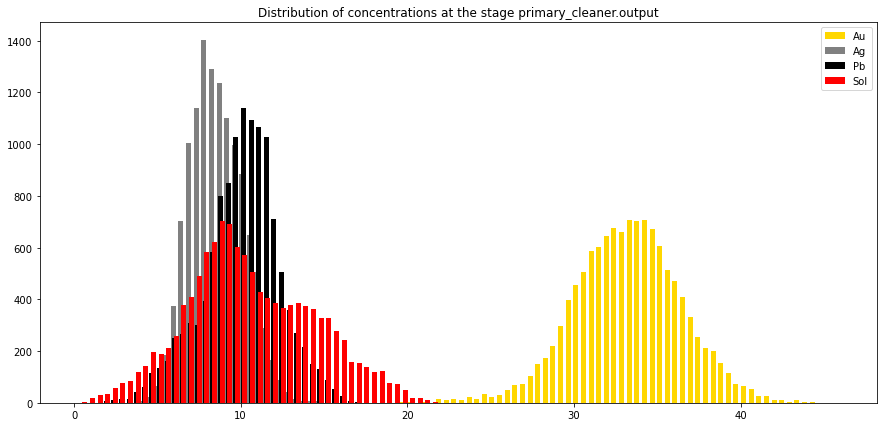

In [60]:
plt.figure(figsize=(15, 7))
plt.title('Distribution of concentrations at the stage primary_cleaner.output')
plt.hist([data_train['primary_cleaner.output.concentrate_au'], data_train['primary_cleaner.output.concentrate_ag'], data_train['primary_cleaner.output.concentrate_pb'], data_train['primary_cleaner.output.concentrate_sol']],
         bins=100, color=['gold', 'gray', 'black', 'red'],
        label=['Au', 'Ag', 'Pb', 'Sol'], width = 0.3);
plt.legend(loc='upper right');

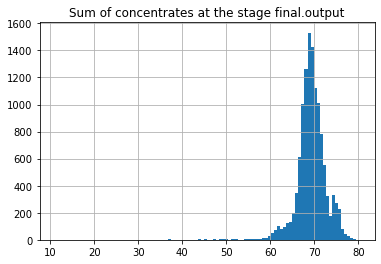

In [61]:
plt.title('Sum of concentrates at the stage final.output')
(data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_sol']).hist(bins=100);

{'whiskers': [<matplotlib.lines.Line2D at 0x1ceca777b20>,
 'caps': [<matplotlib.lines.Line2D at 0x1ceca713d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ceca777940>],
 'medians': [<matplotlib.lines.Line2D at 0x1ceca713370>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ceca713790>],
 'means': []}

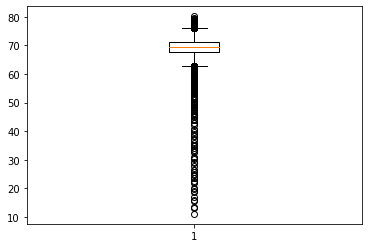

In [62]:
plt.boxplot((data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_sol']))

In [63]:
# удалим выбросы
data_train = data_train[(data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_sol']) > 62]
data_train = data_train[(data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_sol']) < 77]

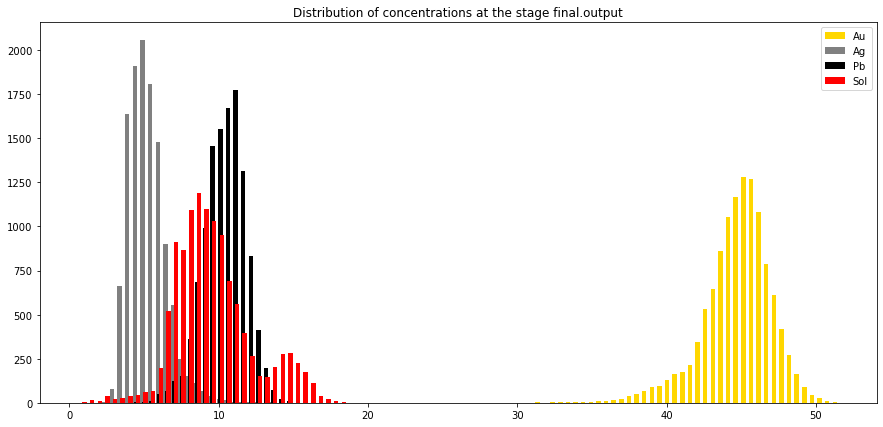

In [64]:
plt.figure(figsize=(15, 7))
plt.title('Distribution of concentrations at the stage final.output')
plt.hist([data_train['final.output.concentrate_au'], data_train['final.output.concentrate_ag'], data_train['final.output.concentrate_pb'], data_train['final.output.concentrate_sol']],
         bins=100, color=['gold', 'gray', 'black', 'red'],
        label=['Au', 'Ag', 'Pb', 'Sol'], width = 0.3);
plt.legend(loc='upper right');

Видно, как проходя по всем этапам технологического процесса, концентрация золота в смеси увеличивалась, относительно концентрации других веществ. Также концентрация становилась стабильнее - уменьшался разброс. <br>
Аномальным значениями считали значения, которые находятся за пределами "усов" диаграммы размаха (те, значения, вероятность которых менее 99%) удалили из тренировочной выборки. Из тестовой выборки удаление проводить не будем, т.к. в реальности этих данных не будет.

# 3. Модель

Аномалии в данных не замечено. Небольшой провал по окнчании этапа первиной очистки может свидетельствовать об увеличении концентрации других, вещест взамен очищенных.

Напишем функцию для вычисления итоговой метрики:

In [65]:
def metrics_sMAPE(target, value):
    return (abs(target-value) / ((abs(target) + abs(value))/2)).sum() * 1/len(target) * 100

In [66]:
def metrics_total_sMAPE(target, value):
    final_sMAPE = (abs(target['final.output.recovery']-value[:, 1]) / ((abs(target['final.output.recovery']) + abs(value[:, 1]))/2)).sum() * 1/len(target['final.output.recovery']) * 100
    rougher_sMAPE = (abs(target['rougher.output.recovery']-value[:, 0]) / ((abs(target['rougher.output.recovery']) + abs(value[:, 0]))/2)).sum() * 1/len(target['rougher.output.recovery']) * 100
    return 0.25*rougher_sMAPE + 0.75*final_sMAPE

In [67]:
score_sMAPE = make_scorer(metrics_sMAPE, greater_is_better=False)

In [68]:
score_total_sMAPE = make_scorer(metrics_total_sMAPE, greater_is_better=False)

Подготовим данные для обучения модели

Сначала удалим признаки, которых нет в тестовой выборке:

In [69]:
data_train = data_train.drop(list(set(missing_features) & set(list(data_train)) - set(['rougher.output.recovery', 'final.output.recovery'])), axis=1)

In [70]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11764 entries, 0 to 13089
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        11764 non-null  object 
 1   final.output.recovery                       11764 non-null  float64
 2   primary_cleaner.input.sulfate               11764 non-null  float64
 3   primary_cleaner.input.depressant            11764 non-null  float64
 4   primary_cleaner.input.feed_size             11764 non-null  float64
 5   primary_cleaner.input.xanthate              11764 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      11764 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    11764 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      11764 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    11764 non-null  float64
 10  primary_cl

Выполним масштабирование признаков обучающей выборки:

In [71]:
numeric = list(data_train)[1:]
numeric.remove('rougher.output.recovery')
numeric.remove('final.output.recovery')

scaler = StandardScaler()
scaler.fit(data_train[numeric])
data_train_scale = data_train
data_train_scale[numeric] = scaler.transform(data_train[numeric])

Посмотрим на корреляцию признаков, чтобы понять, какие признаки имеют связь с целевым и посмотрим, нет ли утечки целевого признака:

In [72]:
abs(data_train_scale.corr(method='spearman').loc[:, 'final.output.recovery']).sort_values(ascending=False)

final.output.recovery                         1.000000
rougher.output.recovery                       0.644475
rougher.input.feed_ag                         0.398273
primary_cleaner.input.sulfate                 0.383956
rougher.input.feed_au                         0.366001
rougher.input.floatbank10_xanthate            0.327400
rougher.input.floatbank11_xanthate            0.305584
rougher.state.floatbank10_a_air               0.258217
rougher.state.floatbank10_c_air               0.244572
rougher.state.floatbank10_d_air               0.234921
secondary_cleaner.state.floatbank4_a_air      0.234129
primary_cleaner.input.xanthate                0.229500
rougher.input.feed_pb                         0.220790
rougher.state.floatbank10_b_air               0.215411
secondary_cleaner.state.floatbank2_a_air      0.207286
secondary_cleaner.state.floatbank3_a_air      0.196607
secondary_cleaner.state.floatbank4_b_air      0.194921
rougher.input.feed_sol                        0.193263
secondary_

In [73]:
abs(data_train_scale.corr(method='spearman').loc[:, 'rougher.output.recovery']).sort_values(ascending=False)

rougher.output.recovery                       1.000000
final.output.recovery                         0.644475
rougher.state.floatbank10_a_air               0.451145
secondary_cleaner.state.floatbank4_a_air      0.430114
secondary_cleaner.state.floatbank4_b_air      0.423724
rougher.state.floatbank10_d_air               0.415485
rougher.state.floatbank10_c_air               0.401795
primary_cleaner.input.sulfate                 0.401610
rougher.input.feed_pb                         0.382333
rougher.input.feed_ag                         0.370343
rougher.state.floatbank10_b_air               0.365820
rougher.state.floatbank10_a_level             0.349226
rougher.input.feed_au                         0.338719
secondary_cleaner.state.floatbank2_a_air      0.333927
secondary_cleaner.state.floatbank3_a_air      0.313861
rougher.input.floatbank10_xanthate            0.300408
rougher.state.floatbank10_e_air               0.291690
secondary_cleaner.state.floatbank2_b_air      0.283733
rougher.st

Удалим признаки с низкой корреляцией

In [74]:
f1 = (abs(data_train_scale.corr(method='spearman').loc[:, 'final.output.recovery']).sort_values(ascending=False))
f2 = abs(data_train_scale.corr(method='spearman').loc[:, 'rougher.output.recovery']).sort_values(ascending=False)
unimportant_feature = list(set(list(f1[f1 < 0.2].index) + list(f2[f2 < 0.2].index)))

In [75]:
data_train_scale = data_train_scale.drop(unimportant_feature, axis=1)

Так как целевой признак для тестовой выборки недоступен, то разделим тренировочную выборку на тренировочную и тестовую:

In [76]:
target = data_train_scale.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
features = data_train_scale.drop(['date', 'rougher.output.recovery', 'final.output.recovery'] , axis=1)

Обучим и проверим несколько моделей. Начнём с модели линейной регрессии:

In [77]:
model_linear_regression_rougher = LinearRegression()
print('Итоговое sMAPE для модели линейной регрессии: {:.3}%'
      .format((cross_val_score(model_linear_regression_rougher, features, target, cv=5, scoring=score_total_sMAPE).mean())*-1))

Итоговое sMAPE для модели линейной регрессии: 6.95%


Попробуем использовать две модели для предсказания двух целевых значений или одну. <br>
Посмотрим, какой способ лучше <br>
При помощи кросс-валидации подберём наилучшие гиперпараметры для случайного леса

In [78]:
%%time

model_rougher_forest_GS = RandomForestRegressor(random_state=12345)
param_grid = {
    'n_estimators' : [i for i in range(70,111,5)],
    'max_depth' : [i for i in range(3,15,2)]
}

CV_model_forest_GS = GridSearchCV(estimator=model_rougher_forest_GS, param_grid=param_grid, cv= 5, scoring=score_sMAPE, n_jobs=-1)
CV_model_forest_GS.fit(features, target['rougher.output.recovery'])
CV_model_forest_GS.best_params_

depth_forest_rougher = CV_model_forest_GS.best_params_['max_depth']
estimators_rougher = CV_model_forest_GS.best_params_['n_estimators']

rougher_sMAPE = (CV_model_forest_GS.best_score_)*-1
print('Лучшее значение sMAPE при кросс-валидации: ', rougher_sMAPE)
print('Лучший результат при проверке модели случайного леса получен: n_estimators = {:}, max_depth = {:}'
      .format(estimators_rougher, depth_forest_rougher))

Лучшее значение sMAPE при кросс-валидации:  5.678502328406662
Лучший результат при проверке модели случайного леса получен: n_estimators = 110, max_depth = 5
Wall time: 3min 50s


In [79]:
%%time

model_final_forest_GS = RandomForestRegressor(random_state=12345)
param_grid = {
    'n_estimators' : [i for i in range(70,111,5)],
    'max_depth' : [i for i in range(3,15,2)]
}

CV_model_forest_GS = GridSearchCV(estimator=model_final_forest_GS, param_grid=param_grid, cv= 5, scoring=score_sMAPE, n_jobs=-1)
CV_model_forest_GS.fit(features, target['final.output.recovery'])
CV_model_forest_GS.best_params_

depth_forest_final = CV_model_forest_GS.best_params_['max_depth']
estimators_final = CV_model_forest_GS.best_params_['n_estimators']

final_sMAPE = (CV_model_forest_GS.best_score_)*-1
print('Лучшее значение sMAPE: ', final_sMAPE)
print('Лучший результат при проверке модели случайного леса получен: n_estimators = {:}, max_depth = {:}'
      .format(estimators_final, depth_forest_final))

Лучшее значение sMAPE:  6.797724841913201
Лучший результат при проверке модели случайного леса получен: n_estimators = 80, max_depth = 5
Wall time: 3min 46s


Посчитаем итоговое sMAPE:

In [80]:
print('Итоговое sMAPE: {:.3}%'.format(0.25*rougher_sMAPE + 0.75*final_sMAPE))

Итоговое sMAPE: 6.52%


Теперь попробуем использовать одну модель для предсказания обоих признаков:

In [81]:
%%time

model_total_recovery_forest_GS = RandomForestRegressor(random_state=12345)
param_grid = {
    'n_estimators' : [i for i in range(70,111,5)],
    'max_depth' : [i for i in range(3,15,2)]    
}

CV_model_forest_GS = GridSearchCV(estimator=model_total_recovery_forest_GS, param_grid=param_grid, cv= 5, scoring=score_total_sMAPE, n_jobs=-1)
CV_model_forest_GS.fit(features, target)
CV_model_forest_GS.best_params_

depth_forest_full = CV_model_forest_GS.best_params_['max_depth']
estimators_full = CV_model_forest_GS.best_params_['n_estimators']

final_sMAPE = (CV_model_forest_GS.best_score_)*-1
print('Лучшее значение итогового sMAPE: ', final_sMAPE)
print('Лучший результат при проверке модели случайного леса получен: n_estimators = {:}, max_depth = {:}'
      .format(estimators_full, depth_forest_full))

Лучшее значение итогового sMAPE:  6.754396998772383
Лучший результат при проверке модели случайного леса получен: n_estimators = 75, max_depth = 7
Wall time: 4min 1s


Итоговые результаты метрики sMAPE, полученные локально, для:
1. модели линейной регрессии 7.69%
2. двух моделей случайного леса 6.83%
3. одной модели случайного леса 6.85%


Применим модели к тестовой выборке.

Обучим модели на полном наборе тренировочных данных:

In [82]:
model_rougher = RandomForestRegressor(n_estimators = 80, max_depth = 5, random_state=12345, n_jobs=-1)
model_final = RandomForestRegressor(n_estimators = 105, max_depth = 9, random_state=12345, n_jobs=-1)
model_full = RandomForestRegressor(n_estimators = estimators_full, max_depth = depth_forest_full, random_state=12345, n_jobs=-1)

In [83]:
model_LR = LinearRegression()
model_LR.fit(features, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
model_rougher.fit(features, target['rougher.output.recovery'])
model_final.fit(features, target['final.output.recovery'])
model_full.fit(features, target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=-1, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

Масштабируем тестовые данные:

In [85]:
data_test_scale = data_test.drop('date', axis=1)
data_test_scale[numeric] = scaler.transform(data_test[numeric])

In [86]:
data_test_scale = data_test_scale.drop(unimportant_feature, axis=1)

Проверим модели на тестовых данных:

In [87]:
rougher_predict = model_rougher.predict(data_test_scale)
final_predict = model_final.predict(data_test_scale)
full_predict = model_full.predict(data_test_scale)

In [88]:
linear_regee_predict = model_LR.predict(data_test_scale)

In [89]:
answers = pd.merge(left=data_test, right=data_full.loc[:, ['date', 'rougher.output.recovery', 'final.output.recovery']], 
         on='date', how='left').loc[:, ['rougher.output.recovery', 'final.output.recovery']]

In [90]:
print('Итоговое sMAPE для модели случайный лес, предсказывающей сразу 2 признака: {:.4}%'.format(
metrics_total_sMAPE(answers, full_predict)))

Итоговое sMAPE для модели случайный лес, предсказывающей сразу 2 признака: 9.368%


In [91]:
print('Итоговое sMAPE для двух моделей предсказывающих признаки раздельно: {:.4}%'.format(
metrics_total_sMAPE(answers, np.array([rougher_predict, final_predict]).T)))

Итоговое sMAPE для двух моделей предсказывающих признаки раздельно: 8.989%


Модели показывают одинаковое значение sMAPE порядка 8.8%

In [92]:
print('Итоговое sMAPE для модели линейной регрессии: {:.4}%'.format(
metrics_total_sMAPE(answers, linear_regee_predict)))

Итоговое sMAPE для модели линейной регрессии: 8.448%


Сравним модели с константной, предсказывающей среднее/медианное значение:

In [93]:
target_roughter_median = [target['rougher.output.recovery'].median() for i in range(len(target['rougher.output.recovery']))]
target_roughter_mean = [target['rougher.output.recovery'].mean() for i in range(len(target['rougher.output.recovery']))]
target_final_median = [target['final.output.recovery'].median() for i in range(len(target['final.output.recovery']))]
target_final_mean = [target['final.output.recovery'].mean() for i in range(len(target['final.output.recovery']))]

median_model_predict = np.array([target_roughter_median, target_final_median]).T
mean_model_predict = np.array([target_roughter_mean, target_final_mean]).T

print('Итогове sMAPE для медианной модели: {:.4}% \nИтогове sMAPE для модели всегда предсказывающей среднее: {:.4}%:'.format(
    metrics_total_sMAPE(target, median_model_predict),
    metrics_total_sMAPE(target, mean_model_predict)
))

Итогове sMAPE для медианной модели: 7.456% 
Итогове sMAPE для модели всегда предсказывающей среднее: 7.461%:


## Вывод:
В результате работы было выяснено, как меняется концентрация веществ на разных этапах технологического процесса/

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке